In [295]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import os
import openai
import numpy as np
import ipdb
import re
from tqdm import tqdm

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
import spacy
import scipy

nlp = spacy.load("en_core_web_sm")
openai.api_key= os.environ['OPENAI_KEY']

from data_utils import *
from gpt3_utils import *
from eval_utils import *

import copy

pd.set_option('max_rows',500,'max_colwidth',1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
data_name = 'bc5cdr_disease'
seed = 42
few_shot_num = 5
number_of_test_samples = 50
selection_strategy = 'random'
sep = ', '
engine='davinci'

prompt_filename = '../data/{}_test_prompts_{}_{}.{}.{}.{}'.format(data_name, selection_strategy,seed,few_shot_num,number_of_test_samples,sep)
filename_root = prompt_filename.split('/')[-1]
test_ready_prompt_dataset = pickle.load(open(prompt_filename,'rb'))

In [25]:
test_ready_prompt_dataframe = test_ready_prompt_dataset['test_df']

In [28]:
test_ready_prompt_dataset['chosen_prompt_ids']

array([2313,  354, 1397, 1846, 2830])

In [6]:
results_by_prompt_sel_stratified = pickle.load(open('prompt_selection_disease_results.stratify.p','rb'))

In [116]:
best_prompt_id = 4
selected_prompt = '\n\n'.join(results_by_prompt_sel_stratified[best_prompt_id,0]['test_ready_prompt'].values[0].split('\n\n')[:-1])

In [117]:
seed_stats = pd.read_csv('bc5cdr_disease.post_filtering_prompt_results.tsv')

In [118]:
seed_stats = seed_stats.sort_values('ranking_score',ascending=False)

In [119]:
selected_post_filtering_prompt = seed_stats.full_prompt.values[0]

In [120]:
selected_post_filtering_template = 'Does the phrase "{}" refer to a disease?\n'

In [121]:
test_ready_prompt_dataframe['test_ready_prompt'] = [selected_prompt+'\n\n'+empty_prompt for empty_prompt in test_ready_prompt_dataframe['empty_prompts']]

In [122]:
prompts = test_ready_prompt_dataframe.test_ready_prompt.values

In [828]:
print(prompts[0])

Sentence: Intracellular PRL content ranged from 1.9 to 9.4 times control levels, and PRL release in vitro was significantly and consistently higher than controls, after at least 8 days of DES exposure.
Diseases: 

Sentence: In the five rats that developed somatic rigidity, ICP and CVP increased significantly above baseline (delta ICP 7.5 +/-
Diseases: somatic rigidity

Sentence: Source of pain and primitive dysfunction in migraine: an identical site ?
Diseases: pain, migraine

Sentence: We report the case of a 70-year-old hypertensive man with a solitary kidney and chronic renal insufficiency who developed two episodes of transient anuria after losartan administration.
Diseases: hypertensive, chronic renal insufficiency, anuria

Sentence: We observed sinoatrial block due to chronic amiodarone administration in a 5-year-old boy with primary cardiomyopathy, Wolff-Parkinson-White syndrome and supraventricular tachycardia.
Diseases: sinoatrial block, primary cardiomyopathy, wolff-parkinson

In [29]:
filtering = True
logit_bias = 10
sep_logit_bias = 10
new_line_logit_bias = 9

In [23]:
exp_results  = run_gpt3_on_df_post_filtering(engine, 
                                             test_ready_prompt_dataframe,
                                             prompts,
                                             selected_post_filtering_prompt,
                                             selected_post_filtering_template,
                                             max_tokens=30,
                                             sep=sep, 
                                             logit_bias=logit_bias,
                                             sep_logit_bias=sep_logit_bias, 
                                             new_line_logit_bias=new_line_logit_bias,positive_entity_threshold = 0.4
                                            )

NameError: name 'prompts' is not defined

In [30]:
preds_filename_root = filename_root+'.preds.{}'.format(engine)+'{}-{}-{}'.format(logit_bias, sep_logit_bias, new_line_logit_bias)
if filtering:
    preds_filename_root += '.filter'
preds_filename = '../outputs/'+preds_filename_root
preds_filename += '.optimal_selection'
preds_filename

'../outputs/bc5cdr_disease_test_prompts_random_42.5.50., .preds.davinci10-10-9.filter.optimal_selection'

In [31]:
df = pickle.load(open(preds_filename,'rb'))

In [16]:
df = exp_results

NameError: name 'exp_results' is not defined

In [32]:
df, unfiltered_entities_probs  = recalibrate_positive_entity_threshold(df, 'predictions', 0.0)

In [33]:
df = create_bio_preds(df, 'predictions')
f1, precision, recall = conlleval_eval(df.ner_seq,df.bio_preds)

processed 1415 tokens with 60 phrases; found: 130 phrases; correct: 42.
accuracy:  89.12%; (non-O)
accuracy:  89.12%; precision:  32.31%; recall:  70.00%; FB1:  44.21%
                X: precision:  32.31%; recall:  70.00%; FB1:  44.21%  130


,F1,Precision,Recall
0,44.210526,32.307692,70.0


In [760]:
#pickle.dump(df, open(preds_filename,'wb'))

In [825]:
errors = df[df['ner_seq'] != df['bio_preds']][['sents', 'ner_seq', 'bio_preds', 'entities','predictions', 'unfiltered_predictions', 'gpt3_output_predictions']]

In [826]:
errors

,sents,ner_seq,bio_preds,entities,predictions,unfiltered_predictions,gpt3_output_predictions
457,"Following administration of these agents , the presence , and degree of fasciculation were assessed visually on a four point scale by one investigator who was blinded to the drug administered .",O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O,[fasciculation],[],[fasciculation],"({'id': 'cmpl-4HKpQlIpUDxtX2xdhgQ95a919fW7K', 'object': 'text_completion', 'created': 1640036988, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1260, 1265, 1267, 1274, 1274, 1274, 1274, 1274 ], ""token_logprobs"": [ -0.10201308, -7.698572e-06, -9.130952e-06, -0.58429915, -2.7251614e-05, -0.59521985, -0.0032575328, -0.5800667 ], ""tokens"": [ "" fasc"", ""ic"", ""ulation"", ""\n"", ""\n"", ""Sent"", ""ence"", "":"" ], ""top_logprobs"": [ { "" fasc"": -0.10201308 }, { ""ic"": -7.698572e-06 }, { ""ulation"": -9.130952e-06 }, { ""\n"": -0.58429915 }, { ""\n"": -2.7251614e-05 }, { ""Sent"": -0.59521985 }, { ""ence"": -0.0032575328 }, { ..."
2614,One had baseline bicuspid aortic valve and mild aortic regurgitation that progressed to moderate regurgitation .,O O O B I I O O B I O O O O O O,O O O O O O O O B I O O O O O O,"[aortic regurgitation, bicuspid aortic valve]",[aortic regurgitation],"[aortic regurgitation, bicuspid aortic valve]","({'id': 'cmpl-4HKpZxdnUrb1WlOiWkOvZ6UO94kRZ', 'object': 'text_completion', 'created': 1640036997, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1179, 1181, 1184, 1186, 1190, 1193, 1200, 1201, 1203, 1205, 1208, 1210, 1212, 1215, 1217, 1223 ], ""token_logprobs"": [ -0.5900539, -0.0019203541, -2.9311614e-06, -0.12511133, -3.529076e-06, -8.960433e-05, -0.5623245, -0.61070466, -7.224551e-06, -3.883893e-06, -6.3900848e-06, -0.03164256, -7.698572e-06, -2.0966954e-06, -0.0014904045, -0.2977705 ], ""tokens"": [ "" a"", ""ort"", ""ic"", "" reg"", ""urg"", ""itation"", "","", "" b"", ""ic"", ""usp"", ""id"", "" a"", ""ort"", ""ic"", "" valve"", ""\n"" ..."
3911,Peroxisomes in hepatomas and hyperplastic preneoplastic liver lesions induced in mice by 500 ppm alpha - benzene hexachloride were examined histochemically and electron microscopically .,O O B O O O B I O O O O O O O O O O O O O O O O O,O O B O O O O O O O O O O O O O O O O O O O O O O,"[liver lesions, hepatomas]",[hepatomas],"[hepatomas, hyperplastic preneoplastic liver lesions, alpha - benzene hexachloride]","({'id': 'cmpl-4HKpb3sS5RVbdJze5f2PysCvKD57p', 'object': 'text_completion', 'created': 1640036999, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1253, 1259, 1263, 1264, 1270, 1272, 1277, 1281, 1283, 1286, 1291, 1297, 1305, 1306, 1312, 1314, 1319, 1322, 1326, 1329, 1332, 1335, 1335, 1335 ], ""token_logprobs"": [ -0.709855, -0.0006854027, -0.09167667, -0.1368011, -5.7891062e-05, -2.5744682e-06, -0.038682234, -2.5225998e-05, -0.0007440355, -4.277735e-07, -0.021689372, -0.003081797, -0.7086472, -0.068503916, -0.1937124, -0.00047326574, -0.00010998996, -0.000677946, -7.4639065e-06, -2.5744682e-06, -6.396884e-05, -0.59186774, -0.0..."
1090,The differential predictive value of levodopa responsiveness for the outcome of parkinsonian ' off ' signs and LID and the different correlations of ventral lesion volume with dyskinesias and parkinsonian ' off ' signs indicate that different anatomical or pathophysiological substrates may be responsible for the generation of parkinsonian ' off ' signs and dyskinesias .,O O O O O O O O O O O B O O O O O B O O O O O O O O O B O B O O O O O O O O O O O O O O O O O O B O O O O O B O,O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O B O,"[parkinsonian, lid, dyskinesias]",[dyskinesias],"[dys

In [790]:
false_negative_bools = []
false_negative_examples = []

log_probs = []

for i, row in df.iterrows():
    
    ents = row['entities']
    filtered_preds = row['predictions']
    unfiltered_preds = row['unfiltered_predictions']
    
    gpt_output = row['gpt3_output_predictions']
     
    false_negative = False
    
    for pred in unfiltered_preds:
        if pred in ents and pred not in filtered_preds:
            false_negative = True
            false_negative_examples.append(('false_neg', pred, unfiltered_preds, gpt_output[0]['choices'][0]['logprobs']['tokens'],gpt_output[0]['choices'][0]['logprobs']['token_logprobs']))
        elif pred in ents and pred in filtered_preds:
            false_negative_examples.append(('true_pos', pred, unfiltered_preds, gpt_output[0]['choices'][0]['logprobs']['tokens'],gpt_output[0]['choices'][0]['logprobs']['token_logprobs']))
        elif pred not in ents:
            false_negative_examples.append(('true_neg', pred, unfiltered_preds, gpt_output[0]['choices'][0]['logprobs']['tokens'],gpt_output[0]['choices'][0]['logprobs']['token_logprobs']))

    false_negative_bools.append(false_negative)
    log_probs.append((unfiltered_preds, gpt_output[0]['choices'][0]['logprobs']['tokens'],gpt_output[0]['choices'][0]['logprobs']['token_logprobs']))

In [791]:
all_logprobs = []

for tup in log_probs:
    
    unfiltered_preds, tokens, probs = tup
    
    pred_logprobs = {}
        
    unfiltered_preds_stable = list(set([w.replace(',','') for w in unfiltered_preds]))
    if '' in unfiltered_preds_stable:
        unfiltered_preds_stable.remove('')
    unfiltered_preds = copy.deepcopy(unfiltered_preds_stable)

    for pred in unfiltered_preds_stable:
        
        if pred == '':
            continue
        
        curr_token = []
        curr_mean_log_prob = []

        for i, tok in enumerate(tokens):
            tok = tok.lower()
            
            if tok == ',':
                curr_token = []
                curr_mean_log_prob = []
            else:
                curr_token.append(tok)
                curr_mean_log_prob.append(probs[i])

            if tok == '\n' or len(unfiltered_preds) == 0:
                break

            if ''.join(curr_token).strip() == pred:
                assert pred in unfiltered_preds, ipdb.set_trace()
                unfiltered_preds.remove(pred)
                curr_mean_log_prob = float(np.mean(curr_mean_log_prob))
                break
                
#         print(''.join(curr_token).strip(), unfiltered_preds)
    
        assert isinstance(curr_mean_log_prob, float), ipdb.set_trace()
        pred_logprobs[pred] = float(curr_mean_log_prob)#/np.sum(probs)
    
    assert len(pred_logprobs) == len(unfiltered_preds_stable), ipdb.set_trace()
    all_logprobs.append(pred_logprobs)

In [792]:
pred_logprobs

{'pulmonary hypertension': -0.165892392,
 'adult rodents': -0.436610037,
 'fluoxetine': -0.20024067708925}

In [793]:
df['logprobs'] = all_logprobs

In [794]:
df['post_filtering_probs'] = [out[1] for out in df.gpt3_output_predictions]

In [795]:
calibration_matrix = np.array([[0.71581109, 0.        ],
       [0.        , 1.65842055]])

In [796]:
calibration_matrix

array([[0.71581109, 0.        ],
       [0.        , 1.65842055]])

In [797]:
entity_pts = []
entity_cats = []

for i,row in df.iterrows():
    
    logprobs = row['logprobs']
    post_filt = row['post_filtering_probs']
    ents = row['entities']
    
    for phrase in logprobs.keys():
        
        logprob = logprobs[phrase]
        post_filt_prob = post_filt[phrase]
        
        entity_pts.append((phrase in ents, logprob, post_filt_prob[1], phrase))
#         entity_pts.append((phrase in ents, logprob, calibration_matrix.dot(post_filt_prob)[1]))
#         entity_cats.append()

In [798]:
entity_pts = pd.DataFrame(entity_pts)

Text(0, 0.5, 'Post Filtering Scores')

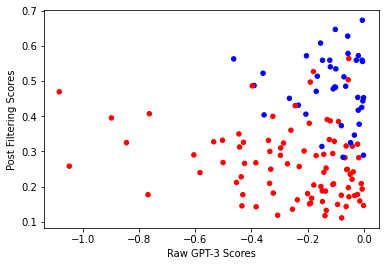

In [799]:
ax = entity_pts.plot.scatter(1,2,c=['blue' if e else 'red' for e in entity_pts[0]],)
ax.set_xlabel("Raw GPT-3 Scores")
ax.set_ylabel("Post Filtering Scores")

In [772]:
#Optimal post-filtering classifier

In [800]:
import sklearn

In [801]:
X = np.array(entity_pts[[1,2]].values)
y = [int(l) for l in entity_pts[0]]

In [775]:
from sklearn.linear_model import LogisticRegression

for i in range(1,100):
    clf = LogisticRegression(random_state=42,class_weight={1:1-i*0.01,0:i*0.01}).fit(X, y)
    print(i,sklearn.metrics.f1_score(y,[c for c in clf.predict(X)]),sklearn.metrics.precision_score(y,[c for c in clf.predict(X)]), sklearn.metrics.recall_score(y,[c for c in clf.predict(X)]))

1 0.6065573770491803 0.43529411764705883 1.0
2 0.6065573770491803 0.43529411764705883 1.0
3 0.6065573770491803 0.43529411764705883 1.0
4 0.6065573770491803 0.43529411764705883 1.0
5 0.6065573770491803 0.43529411764705883 1.0
6 0.6065573770491803 0.43529411764705883 1.0
7 0.6065573770491803 0.43529411764705883 1.0
8 0.6065573770491803 0.43529411764705883 1.0
9 0.6065573770491803 0.43529411764705883 1.0
10 0.6065573770491803 0.43529411764705883 1.0
11 0.6065573770491803 0.43529411764705883 1.0
12 0.6065573770491803 0.43529411764705883 1.0
13 0.6065573770491803 0.43529411764705883 1.0
14 0.6065573770491803 0.43529411764705883 1.0
15 0.6065573770491803 0.43529411764705883 1.0
16 0.6065573770491803 0.43529411764705883 1.0
17 0.6065573770491803 0.43529411764705883 1.0
18 0.6065573770491803 0.43529411764705883 1.0
19 0.6065573770491803 0.43529411764705883 1.0
20 0.6065573770491803 0.43529411764705883 1.0
21 0.6065573770491803 0.43529411764705883 1.0
22 0.6065573770491803 0.43529411764705883 1

/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgut

68 0.0 0.0 0.0
69 0.0 0.0 0.0
70 0.0 0.0 0.0
71 0.0 0.0 0.0
72 0.0 0.0 0.0
73 0.0 0.0 0.0
74 0.0 0.0 0.0
75 0.0 0.0 0.0
76 0.0 0.0 0.0
77 0.0 0.0 0.0
78 0.0 0.0 0.0
79 0.0 0.0 0.0
80 0.0 0.0 0.0
81 0.0 0.0 0.0
82 0.0 0.0 0.0
83 0.0 0.0 0.0
84 0.0 0.0 0.0
85 0.0 0.0 0.0
86 0.0 0.0 0.0
87 0.0 0.0 0.0
88 0.0 0.0 0.0
89 0.0 0.0 0.0
90 0.0 0.0 0.0
91 0.0 0.0 0.0
92 0.0 0.0 0.0
93 0.0 0.0 0.0
94 0.0 0.0 0.0
95 0.0 0.0 0.0
96 0.0 0.0 0.0
97 0.0 0.0 0.0
98 0.0 0.0 0.0
99 0.0 0.0 0.0


/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgutierrez.1/anaconda3/envs/scispacy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jimenezgut

In [736]:
i=32
clf = LogisticRegression(random_state=42,class_weight={1:1-i*0.01,0:i*0.01}).fit(X, y)
print(i,sklearn.metrics.f1_score(y,[c for c in clf.predict(X)]),sklearn.metrics.precision_score(y,[c for c in clf.predict(X)]), sklearn.metrics.recall_score(y,[c for c in clf.predict(X)]))

32 0.6434782608695652 0.47435897435897434 1.0


In [802]:
clf = LogisticRegression(random_state=42,class_weight='balanced').fit(X, y)

In [738]:
from sklearn.svm import SVC
clf = SVC(kernel='poly',class_weight='balanced').fit(X, y)

In [739]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(class_weight='balanced').fit(X, y)

In [803]:
clf.score(X,y)

0.875968992248062

Text(0, 0.5, 'Post Filtering Scores')

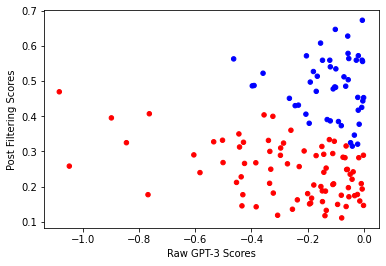

In [804]:
ax = entity_pts.plot.scatter(1,2,c=['blue' if e==1 else 'red' for e in clf.predict(X)])
ax.set_xlabel("Raw GPT-3 Scores")
ax.set_ylabel("Post Filtering Scores")

In [805]:
entity_pts['preds'] = clf.predict(X)

In [806]:
entity_pts

,0,1,2,3,preds
0,False,-0.272014,0.264804,amphetamine,0
1,False,-0.079075,0.110833,benzoylecgonine,0
2,False,-0.048974,0.235047,cocaine,0
3,False,-0.134405,0.252653,mwm,0
4,False,-0.297030,0.288995,4 trial / day,0
5,True,-0.121388,0.559597,syncope,1
6,True,-0.101818,0.647336,edema,1
7,False,-0.147481,0.157213,amlodipine,0
8,False,-0.055288,0.196956,valsartan plus amlodipine,0
9,False,-0.014667,0.158929,valsartan,0


In [807]:
opt_filtering = []

for i,row in df.iterrows():
    opt_filtering_row = []

    ents = row['entities']
    unfiltered_preds = row['unfiltered_predictions']
    gpt3_scores = row['logprobs']
    post_filt_scores = row['post_filtering_probs']
    
    unfiltered_preds = list(set([w.replace(',','') for w in unfiltered_preds]))
    if '' in unfiltered_preds:
        unfiltered_preds.remove('')
        
    for phrase in unfiltered_preds:
        if phrase == '':
            continue
        phrase_features = np.array([[gpt3_scores[phrase], post_filt_scores[phrase][1]]])
        pred = clf.predict(phrase_features)
        
        if pred[0] == 1:
            opt_filtering_row.append(phrase)

    opt_filtering.append(opt_filtering_row)

df['optimal_filtering_predictions'] = opt_filtering

In [808]:
df[['entities','optimal_filtering_predictions','unfiltered_predictions','gpt3_output_predictions']]

,entities,optimal_filtering_predictions,unfiltered_predictions,gpt3_output_predictions
1078,[],[],"[amphetamine, cocaine, benzoylecgonine]","({'id': 'cmpl-4HKpEgKyjyghEAVJkeYducZO3QZIi', 'object': 'text_completion', 'created': 1640036976, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1193, 1197, 1205, 1206, 1214, 1215, 1220, 1224, 1225, 1228, 1231, 1231, 1231, 1231, 1231, 1231 ], ""token_logprobs"": [ -0.5440254, -2.8138238e-06, -0.05453377, -0.04897361, -0.8086857, -0.39530605, -4.275062e-05, -7.3446927e-06, -2.693682e-06, -1.5925843e-05, -0.4736496, -0.0001419407, -0.40056127, -0.0020632711, -0.31582117, -0.0021276006 ], ""tokens"": [ "" amp"", ""hetamine"", "","", "" cocaine"", "","", "" benz"", ""oyle"", ""c"", ""gon"", ""ine"", ""\n"", ""\n"", ""Pl"", ""asma"", "" was"", "" t..."
2098,[],[],[],"({'id': 'cmpl-4HKpG5cF4ufV7bRuxdN3ChhsO2emf', 'object': 'text_completion', 'created': 1640036978, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1070, 1070, 1070, 1070, 1070, 1070, 1070, 1070 ], ""token_logprobs"": [ -0.03526502, -0.0033913136, -0.14003229, -0.102366135, -0.006502068, -0.04217586, -0.0015438314, -0.015822208 ], ""tokens"": [ ""\n"", ""\n"", ""4"", "" ."", ""\n"", ""\n"", ""4"", "" ."" ], ""top_logprobs"": [ { ""\n"": -0.03526502 }, { ""\n"": -0.0033913136 }, { ""4"": -0.14003229 }, { "" ."": -0.102366135 }, { ""\n"": -0.006502068 }, { ""\n"": -0.04217586 }, { ""4"": -0.0015438314 }, { "" ."": -0.015822208 ..."
1648,[],[],"[mwm, 4 trial / day]","({'id': 'cmpl-4HKpHrclDxrD6aGV69ovwFIRWLsiH', 'object': 'text_completion', 'created': 1640036979, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1198, 1200, 1202, 1203, 1205, 1211, 1213, 1217 ], ""token_logprobs"": [ -0.26783884, -0.0009721014, -0.46177584, -0.92155665, -0.15274069, -0.11287617, -0.0009475791, -0.57860005 ], ""tokens"": [ "" M"", ""WM"", "","", "" 4"", "" trial"", "" /"", "" day"", ""\n"" ], ""top_logprobs"": [ { "" M"": -0.26783884 }, { ""WM"": -0.0009721014 }, { "","": -0.46177584 }, { "" 4"": -0.92155665 }, { "" trial"": -0.15274069 }, { "" /"": -0.11287617 }, { "" day"": -0.0009475791 }, { ""\n"": -0.5786000..."
3489,[syncope],[syncope],[syncope],"({'id': 'cmpl-4HKpI484W0UEForxB873h58DxAPUx', 'object': 'text_completion', 'created': 1640036980, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1183, 1188, 1191, 1191, 1191, 1191, 1191, 1191 ], ""token_logprobs"": [ -0.24277338, -2.5744682e-06, -0.36576077, -0.00019857421, -0.042430922, -1.1427999, -0.63788164, -1.137957 ], ""tokens"": [ "" sync"", ""ope"", ""\n"", ""\n"", ""A"", "" higher"", "" dose"", "" was"" ], ""top_logprobs"": [ { "" sync"": -0.24277338 }, { ""ope"": -2.5744682e-06 }, { ""\n"": -0.36576077 }, { ""\n"": -0.00019857421 }, { ""A"": -0.042430922 }, { "" higher"": -1.1427999 }, { "" dose"": -0.63788164 }, { ..."
4146,[edema],[edema],"[edema, amlodipine, valsartan, valsartan plus amlodipine, amlodipine]","({'id': 'cmpl-4HKpJzShAny8IUd801jXZupsvHLuj', 'object': 'text_completion', 'created': 1640036981, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""length"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1337, 1340, 1343, 1344, 1347, 1348, 1350, 1352, 1355, 1356, 1358, 1361, 1364, 1366, 1367, 1369, 1372, 1375, 1377, 1382, 1385, 1386, 1388, 1390, 1393, 1394, 1397, 1398, 1400, 1402 ], ""token_logprobs"": [ -0.20362659, -1.0204763e-05, -0.45039594, -0.73704743, -0.00031739712, -1.0084622e-05, -2.200643e-05, -8.296486e-06, -0.17671126, -0.05859398, -1.37819625e-05, -1.8907942e-05, -4.0009756e-05, -0.12083728, -0.10932588, -6.9573514e-05, -3.6195077e-05, -1.1514188e-05, -0...."
369,[],[],"[angiographies, ionic, non - ionic, average dose, contrast material]","({'id': 'cmpl-4HKpLXb

In [809]:
df = create_bio_preds(df, 'optimal_filtering_predictions')
f1, precision, recall = conlleval_eval(df.ner_seq,df.bio_preds)

processed 1415 tokens with 60 phrases; found: 49 phrases; correct: 38.
accuracy:  96.33%; (non-O)
accuracy:  96.33%; precision:  77.55%; recall:  63.33%; FB1:  69.72%
                X: precision:  77.55%; recall:  63.33%; FB1:  69.72%  49


In [515]:
df

,sents,ner_seq,bio_preds,entities,num_entities,num_tokens,prompts,empty_prompts,test_ready_prompt,predictions,unfiltered_predictions,gpt3_output_predictions,predictions.post,logprobs,post_filtering_probs,optimal_filtering_predictions,optimal_filtering_predictions.post
1078,Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .,O O O O O O O O O O O O O O O O O,O O O O O O O O O O O O O O O O O,[],0,0,Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .\nDiseases:,Sentence: Plasma was tested for amphetamine and the cocaine metabolite benzoylecgonine using enzyme - mediated immunoassay methodology .\nDiseases:,"Sentence: Intracellular PRL content ranged from 1.9 to 9.4 times control levels, and PRL release in vitro was significantly and consistently higher than controls, after at least 8 days of DES exposure.\nDiseases: \n\nSentence: In the five rats that developed somatic rigidity, ICP and CVP increased significantly above baseline (delta ICP 7.5 +/-\nDiseases: somatic rigidity\n\nSentence: Source of pain and primitive dysfunction in migraine: an identical site ?\nDiseases: pain, migraine\n\nSentence: We report the case of a 70-year-old hypertensive man with a solitary kidney and chronic renal insufficiency who developed two episodes of transient anuria after losartan administration.\nDiseases: hypertensive, chronic renal insufficiency, anuria\n\nSentence: We observed sinoatrial block due to chronic amiodarone administration in a 5-year-old boy with primary cardiomyopathy, Wolff-Parkinson-White syndrome and supraventricular tachycardia.\nDiseases: sinoatrial block, primary cardiomyopathy...",[],"[amphetamine, cocaine, benzoylecgonine]","({'id': 'cmpl-4HKpEgKyjyghEAVJkeYducZO3QZIi', 'object': 'text_completion', 'created': 1640036976, 'model': 'davinci:2020-05-03', 'choices': [{ ""finish_reason"": ""stop"", ""index"": 0, ""logprobs"": { ""text_offset"": [ 1193, 1197, 1205, 1206, 1214, 1215, 1220, 1224, 1225, 1228, 1231, 1231, 1231, 1231, 1231, 1231 ], ""token_logprobs"": [ -0.5440254, -2.8138238e-06, -0.05453377, -0.04897361, -0.8086857, -0.39530605, -4.275062e-05, -7.3446927e-06, -2.693682e-06, -1.5925843e-05, -0.4736496, -0.0001419407, -0.40056127, -0.0020632711, -0.31582117, -0.0021276006 ], ""tokens"": [ "" amp"", ""hetamine"", "","", "" cocaine"", "","", "" benz"", ""oyle"", ""c"", ""gon"", ""ine"", ""\n"", ""\n"", ""Pl"", ""asma"", "" was"", "" t...",[],"{'amphetamine': -0.2720141069119, 'benzoylecgonine': -0.07907495296754, 'cocaine': -0.04897361}","{'amphetamine': [0.7351955248487391, 0.26480447515126093], 'cocaine': [0.7649533488325295, 0.2350466511674706], 'benzoylecgonine': [0.8891673292040305, 0.11083267079596942]}",[],[]
2098,4 .,O O,O O,[],0,0,Sentence: 4 .\nDiseases:,Sentence: 4 .\nDiseases:,"Sentence: Intracellular PRL content ranged from 1.9 to 9.4 times control levels, and PRL release in vitro was significantly and consistently higher than controls, after at least 8 days of DES exposure.\nDiseases: \n\nSentence: In the five rats that developed somatic rigidity, ICP and CVP increased significantly above baseline (delta ICP 7.5 +/-\nDiseases: somatic rigidity\n\nSentence: Source of pain and primitive dysfunction in migraine: an identical site ?\nDiseases: pain, migraine\n\nSentence: We report the case of a 70-year-old hypertensive man with a solitary kidney and chronic renal insufficiency who developed two episodes of transient anuria after losartan administration.\nDiseases: hypertensive, chronic renal insufficiency, anuria\n\nSentence: We observed sinoatrial block due to chronic amiodarone administration in a 5-year-old boy with primary cardiomyopathy, Wolff-Parkinson-White syndrome and supraventricular tachycardia.\nDiseases: sinoatrial block, primary cardiomyopathy...",[],[],"({'id': 'cmpl-4HKpG5cF4ufV7bRuxdN3ChhsO2emf', 'object': 'text_completion', 'create